In [4]:
!pip install pandas requests lxml html5lib beautifulsoup4 matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
mb_stats_2024_25_url = 'https://www.espn.com/nba/team/stats/_/name/mil/milwaukee-bucks'

nba_standings_2024_25 = "https://www.espn.com/nba/standings"

nba_standings_2024_25_league = "https://www.espn.com/nba/standings/_/group/league"

nba_standings_2023_24_league = "https://www.espn.com/nba/standings/_/season/2024/group/league"

extra_data_milwaukee_bucks = "https://www.espn.com.br/nba/time/estatisticas/_/nome/mil/table/game/ordenar/gamesPlayed/dir/desce"
extra_data_milwaukee_bucks_2024 = "https://www.espn.com.br/nba/time/estatisticas/_/nome/mil/temporada/2025/tipodetemporada/3/table/game/ordenar/gamesPlayed/dir/desce"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}

def read_html_with_requests(file_url):
    response = requests.get(file_url, headers=headers)
    df = pd.read_html(response.content)
    return df

In [7]:
def format_all_players_data(url_data, merge_on):
  df = read_html_with_requests(url_data)
  df1 = pd.concat([df[0], df[1]], axis=1)
  df2 = pd.concat([df[2], df[3]], axis=1)
  tdf = pd.merge(df1, df2, on=merge_on)
  return tdf

In [8]:
def clean_team_name(name):
    name = name.split("--")[1] if '--' in name else name
    name = name.lstrip('0123456789') if any(name.startswith(str(i)) for i in range(1, 11)) else name
    return name[3:]

def format_df_without_column_name(df):
    df.loc[-1] = [df.columns[0]]
    df.index = df.index + 1
    df = df.sort_index()
    df.rename(columns={df.columns[0]: 'Name'}, inplace=True)
    df['Name'] = df['Name'].apply(clean_team_name)
    return df

def format_all_teams_data():
    df = read_html_with_requests(nba_standings_2024_25)
    eastern_names = format_df_without_column_name(df[0])
    eastern = pd.concat([eastern_names, df[1]], axis=1)
    western_names = format_df_without_column_name(df[2])
    western = pd.concat([western_names, df[3]], axis=1)
    return eastern, western

def format_all_teams_league_data():
    df = read_html_with_requests(nba_standings_2024_25_league)
    df[0] = format_df_without_column_name(df[0])
    df[0].to_json('format_all_teams_data.json', orient='records', lines=True)
    tdf = pd.concat([df[0], df[1]], axis=1)
    return tdf

def get_team_row(df, team_name, column_name):
    return df[ df[column_name] == team_name]

def format_all_teams_league_data_league(season):
    df = read_html_with_requests(nba_standings_2024_25_league if season == 2025  else nba_standings_2023_24_league)
    df[0] = format_df_without_column_name(df[0])
    df[0].to_json('format_all_teams_data_league.json', orient='records', lines=True)
    tdf = pd.concat([df[0], df[1]], axis=1)
    tdf.insert(0, "Season", season)
    return tdf

In [9]:
#RF1
def rf1():
  eastern, western = format_all_teams_data()
  eastern.rename(columns={"Name": "Conferência Leste"}, inplace=True)
  western.rename(columns={"Name": "Conferência Oeste"}, inplace=True)
  return pd.concat([eastern["Conferência Leste"], western["Conferência Oeste"]], axis=1)

In [10]:
#RF2A
def rf2():
  eastern, western = format_all_teams_data()
  eastern.rename(columns={"Name": "Conferência Leste"}, inplace=True)
  eastern.insert(0, "POS-CL", eastern.index + 1)
  (eastern[["POS-CL", "Conferência Leste"]])
  western.rename(columns={"Name": "Conferência Oeste"}, inplace=True)
  western.insert(0, "POS-CO", western.index + 1)
  (western[["POS-CO", "Conferência Oeste"]])
  return pd.concat([eastern[["POS-CL", "Conferência Leste"]], western[["POS-CO", "Conferência Oeste"]]], axis=1)

In [11]:
#RF3
def format_for_ref3(season):
    league_data = format_all_teams_league_data_league(season)
    tdf = get_team_row(league_data, "Milwaukee Bucks","Name")[["Season", "W", "L", "HOME", "AWAY"]]
    tdf[['Total de Vitórias fora de casa', 'Total de Derrotas Fora de casa']] = tdf['AWAY'].str.split('-', expand=True)
    tdf[['Total de Vitórias em Casa', 'Total de Derrotas em casa']] = tdf['HOME'].str.split('-', expand=True)
    tdf.drop(columns=["HOME", "AWAY"], inplace=True)
    tdf.rename(columns={"W": "Total de Vitórias", "L": "Total de Derrotas", "Season": "Temporada"}, inplace=True)
    return tdf[["Temporada", "Total de Vitórias", 'Total de Vitórias em Casa', 'Total de Vitórias fora de casa',
                "Total de Derrotas", 'Total de Derrotas em casa', "Total de Derrotas Fora de casa"]]
def rf3():
  return pd.concat([format_for_ref3(2024),format_for_ref3(2025)], axis=0)

In [12]:
milwaukee_bucks_extra_df = format_all_players_data(extra_data_milwaukee_bucks, "Nome")
milwaukee_bucks_extra_df_2024 = format_all_players_data(extra_data_milwaukee_bucks_2024, "Nome")
total_team_milwaukee_bucks = get_team_row(milwaukee_bucks_extra_df,"Total","Nome")
total_team_milwaukee_bucks_2024 = get_team_row(milwaukee_bucks_extra_df_2024,"Total","Nome")

milwaukee_bucks_extra_df_last_season = format_all_players_data("https://www.espn.com.br/nba/time/estatisticas/_/nome/mil/temporada/2024/tipodetemporada/2/table/game/ordenar/gamesPlayed/dir/desce", "Nome")
total_team_milwaukee_bucks_last_season = get_team_row(milwaukee_bucks_extra_df_last_season,"Total","Nome")


In [13]:
#RF4
def filter_team_stats(df):
    selected_columns = ["Name", "Season", "PPG", "W", "L", "HOME", "AWAY"]
    df_filtered = df[selected_columns].copy()

    df_filtered[["HOME_W", "HOME_L"]] = df_filtered["HOME"].str.split("-", expand=True).astype(int)
    df_filtered[["AWAY_W", "AWAY_L"]] = df_filtered["AWAY"].str.split("-", expand=True).astype(int)

    df_filtered.drop(columns=["HOME", "AWAY"], inplace=True)

    return df_filtered
def ref4():
  tdf_2025 = format_all_teams_league_data_league(2025)
  tdf_2024 = format_all_teams_league_data_league(2024)

  milwaukee_bucks_row_2025 = filter_team_stats(get_team_row(tdf_2025, "Milwaukee Bucks","Name"))

  extra_stats_2025 = total_team_milwaukee_bucks[["AST", "REB", "3PC", "PTS"]].copy()
  extra_stats_2025.columns = ["AST", "REB", "3PC", "PTS"]
  extra_stats_2025.rename(columns={"PTS":"PPG"}, inplace=True)

  milwaukee_bucks_row_2025 = pd.merge(milwaukee_bucks_row_2025, extra_stats_2025, how = 'left', on = 'PPG')
  milwaukee_bucks_row_2024 = filter_team_stats(get_team_row(tdf_2024, "Milwaukee Bucks","Name"))

  extra_stats_2024 = total_team_milwaukee_bucks_last_season[["AST", "REB", "3PC", "PTS"]].copy()

  extra_stats_2024.columns = ["AST", "REB", "3PC", "PTS"]
  extra_stats_2024.rename(columns={"PTS":"PPG"}, inplace=True)


  milwaukee_bucks_row_2024 = pd.merge(milwaukee_bucks_row_2024, extra_stats_2024, how = 'left', on = 'PPG')

  final_df = pd.concat([milwaukee_bucks_row_2025, milwaukee_bucks_row_2024], axis=0)
  final_df = final_df[['Name', 'Season', 'PPG', 'AST', 'REB', '3PC', 'HOME_L', 'AWAY_L']]
  final_df.rename(columns={
    'Name': 'Nome',
    'Season': 'Temporada',
    'PPG': 'Total de Pontos por Jogo',
    'AST': 'Total de Assistências por Jogo',
    'REB': 'Total de Rebotes por Jogo',
    '3PC': 'Total de Cestas de 3 Pontos Convertidas',
    'HOME_L': 'Derrotas em Casa',
    'AWAY_L': 'Derrotas Fora de Casa'
  }, inplace=True)
  return final_df

In [14]:
#RF5
def rf5():
  final_df = pd.concat( [total_team_milwaukee_bucks["REB"].copy(),
                            total_team_milwaukee_bucks["OR"].copy(),
                            total_team_milwaukee_bucks["DR"].copy(),
                            total_team_milwaukee_bucks["PTS"].copy(),
                            total_team_milwaukee_bucks["2PM"].copy(),
                            total_team_milwaukee_bucks["3PC"].copy(),
                            total_team_milwaukee_bucks["FTM"].copy()],axis=1)
  final_df.rename(columns={
    'REB': 'Total de Rebotes',
    'OR': 'Total de Rebotes Ofensivos',
    'DR': 'Total de Rebotes Defensivos',
    'PTS': 'Total de Pontos',
    '2PM': 'Total de Cestas de 2 Pontos',
    '3PC': 'Total de Cestas de 3 Pontos',
    'FTM': 'Total de Lance Livre'
  }, inplace=True)
  return final_df

In [15]:
#RF6
def rf6():
  extra_df_RF6_2025= pd.concat([total_team_milwaukee_bucks["STL"].copy(),
                            total_team_milwaukee_bucks["DR"].copy(),
                            total_team_milwaukee_bucks["BLK"].copy(),
                            total_team_milwaukee_bucks["TO"].copy(),
                            total_team_milwaukee_bucks["PF"].copy()
                            ],axis=1)
  extra_df_RF6_2025["Temporada"] =  "2025"

  extra_df_RF6_2024= pd.concat( [total_team_milwaukee_bucks_2024["STL"].copy(),
                            total_team_milwaukee_bucks_2024["DR"].copy(),
                            total_team_milwaukee_bucks_2024["BLK"].copy(),
                            total_team_milwaukee_bucks_2024["TO"].copy(),
                            total_team_milwaukee_bucks_2024["PF"].copy()
                            ],axis=1)
  extra_df_RF6_2024["Temporada"] =  "2024"

  return pd.concat([extra_df_RF6_2025,extra_df_RF6_2024], axis=0)

In [16]:
#RF7A
def process_milwaukee_bucks_data(raw_data):
    df = raw_data[0]
    df.columns = df.iloc[1]
    df = df[2:].reset_index(drop=True)

    df = df.rename(columns={
        'DATE': 'Data',
        'OPPONENT': 'Opponent',
        'RESULT': 'Result',
        'W-L': 'W-L',
        'Hi Points': 'Hi Points',
        'Hi Rebounds': 'Hi Rebounds',
        'Hi Assists': 'Hi Assists'
    })
    df = df[~df['Result'].str.contains('Tickets', na=False)]
    df = df[~df['Result'].str.contains('PM', na=False)]
    df = df[~df['Result'].str.contains('TIME', na=False)]
    df = df[~df['Result'].str.contains('Postponed', na=False)]
    df['Result'] = df['Result'].apply(lambda x: x.split(' ')[0])
    df[['Hi Points Player', 'Hi Points']] = df['Hi Points'].str.rsplit(' ', n=1, expand=True)
    df[['Hi Rebounds Player', 'Hi Rebounds']] = df['Hi Rebounds'].str.rsplit(' ', n=1, expand=True)
    df[['Hi Assists Player', 'Hi Assists']] = df['Hi Assists'].str.rsplit(' ', n=1, expand=True)
    df['Hi Points'] = pd.to_numeric(df['Hi Points'], errors='coerce')
    df['Hi Rebounds'] = pd.to_numeric(df['Hi Rebounds'], errors='coerce')
    df['Hi Assists'] = pd.to_numeric(df['Hi Assists'], errors='coerce')
    df = df[['Data', 'Opponent', 'Result', 'W-L', 'Hi Points Player', 'Hi Points',
             'Hi Rebounds Player', 'Hi Rebounds', 'Hi Assists Player', 'Hi Assists']]

    return df

def transformar_tabela(df_original):
    df = df_original.copy()
    df = df
    df['Vitória ou Derrota'] = df['Result'].str[0]

    df['Vitória ou Derrota'] = df['Vitória ou Derrota'].replace({'W': 'Vitória', 'L': 'Derrota'})
    df['Placar'] = df['Result'].str[1:]
    df['Casa ou Fora'] = df['Opponent'].apply(lambda x: 'Casa' if x.startswith('vs') else 'Fora')
    df['Adversário'] = df['Opponent'].str.replace('vs ', '').str.replace('@ ', '')
    df_final = df[['Data', 'Adversário', 'Vitória ou Derrota', 'Casa ou Fora', 'Placar']]

    return df_final

def rf7():
  last_games_milwaukee_2025 = read_html_with_requests("https://www.espn.com/nba/team/schedule/_/name/mil/milwaukee-bucks")
  df_original_2025 = process_milwaukee_bucks_data(last_games_milwaukee_2025)
  df_transformado_2025 = transformar_tabela(df_original_2025)
  df_transformado_2025[["Temporada"]] = "2025"
  last_games_milwaukee_2024 = read_html_with_requests("https://www.espn.com/nba/team/schedule/_/name/mil/season/2024")
  df_original_2024 = process_milwaukee_bucks_data(last_games_milwaukee_2024)
  df_transformado_2024 = transformar_tabela(df_original_2024)
  df_transformado_2024[["Temporada"]] = "2024"
  return pd.concat([df_transformado_2024, df_transformado_2025])


In [17]:
rf1df = rf1()
rf2df = rf2()
rf3df = rf3()
rf4df = ref4()
rf5df = rf5()
rf6df = rf6()
rf7df = rf7()

print("-------------RF1-------------")
print(rf1df)
print("-------------RF2-------------")
print(rf2df)
print("-------------RF3-------------")
print(rf3df)
print("-------------RF4-------------")
print(rf4df)
print("-------------RF5-------------")
print(rf5df)
print("-------------RF6-------------")
print(rf6df)
print("-------------RF7-------------")
print(rf7df)

print("-------------RF1-------------")
print(rf1df.columns)
print("-------------RF2-------------")
print(rf2df.columns)
print("-------------RF3-------------")
print(rf3df.columns)
print("-------------RF4-------------")
print(rf4df.columns)
print("-------------RF5-------------")
print(rf5df.columns)
print("-------------RF6-------------")
print(rf6df.columns)
print("-------------RF7-------------")
print(rf7df.columns)

from pathlib import Path
Path("results/pt1/").mkdir(parents=True, exist_ok=True)

rf1df.to_csv('results/pt1/rf1.csv', index=False)
rf2df.to_csv('results/pt1/rf2.csv', index=False)
rf3df.to_csv('results/pt1/rf3.csv', index=False)
rf4df.to_csv('results/pt1/rf4.csv', index=False)
rf5df.to_csv('results/pt1/rf5.csv', index=False)
rf6df.to_csv('results/pt1/rf6.csv', index=False)
rf7df.to_csv('results/pt1/rf7.csv', index=False)

-------------RF1-------------
      Conferência Leste       Conferência Oeste
0   Cleveland Cavaliers   Oklahoma City Thunder
1        Boston Celtics       Memphis Grizzlies
2        ew York Knicks          Denver Nuggets
3        Indiana Pacers         Houston Rockets
4       Milwaukee Bucks      Los Angeles Lakers
5       Detroit Pistons             LA Clippers
6         Orlando Magic  Minnesota Timberwolves
7         Atlanta Hawks        Dallas Mavericks
8            Miami Heat        Sacramento Kings
9         Chicago Bulls    olden State Warriors
10   Philadelphia 76ers            Phoenix Suns
11        Brooklyn Nets        an Antonio Spurs
12      Toronto Raptors  Portland Trail Blazers
13    Charlotte Hornets              HUtah Jazz
14   Washington Wizards     ew Orleans Pelicans
-------------RF2-------------
    POS-CL    Conferência Leste  POS-CO       Conferência Oeste
0        1  Cleveland Cavaliers       1   Oklahoma City Thunder
1        2       Boston Celtics       2     

<Figure size 800x500 with 0 Axes>

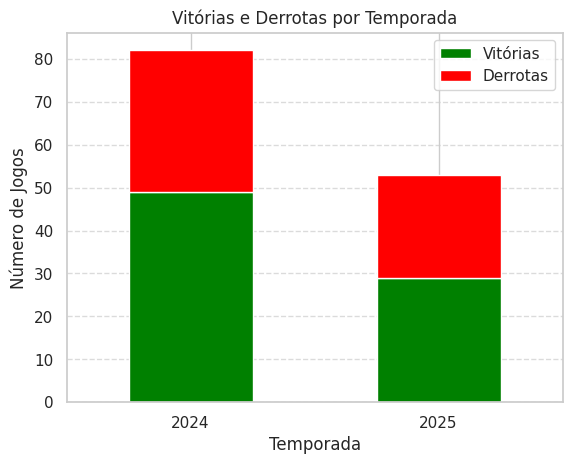

<Figure size 800x500 with 0 Axes>

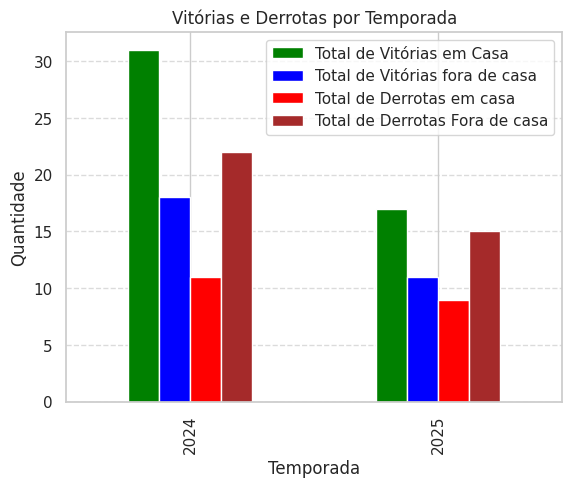

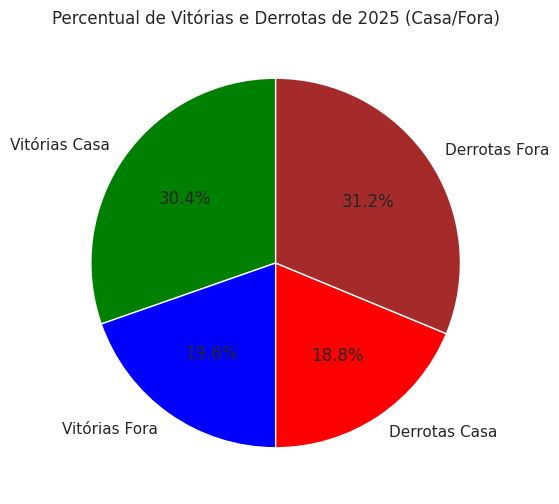

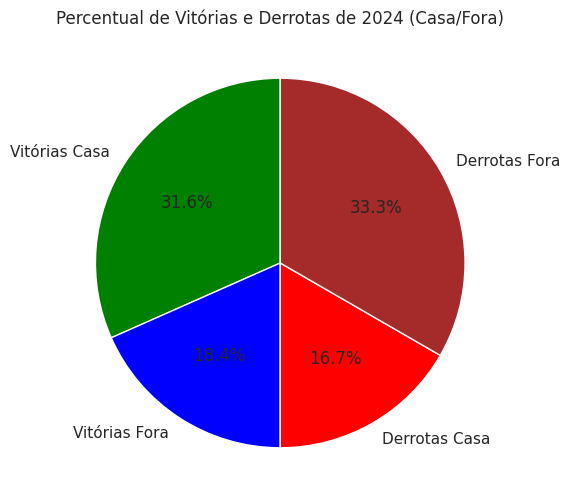

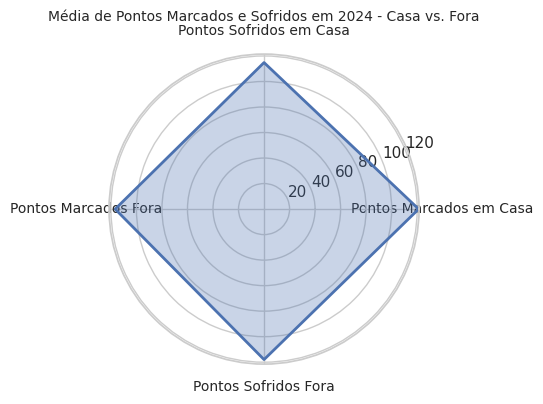

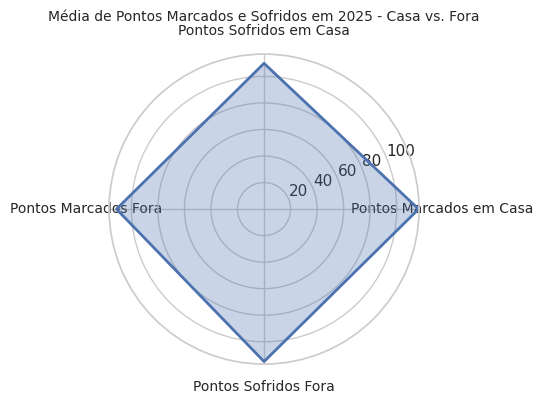

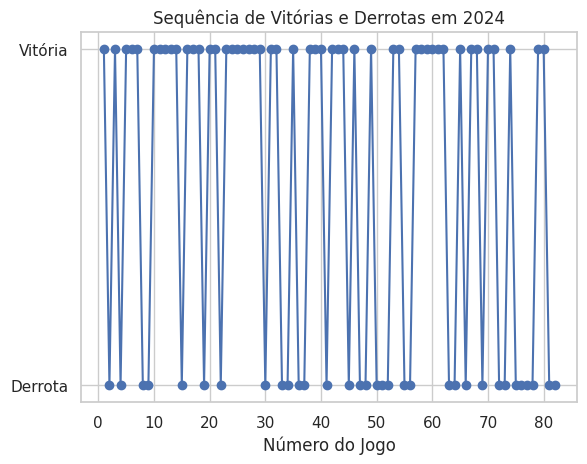

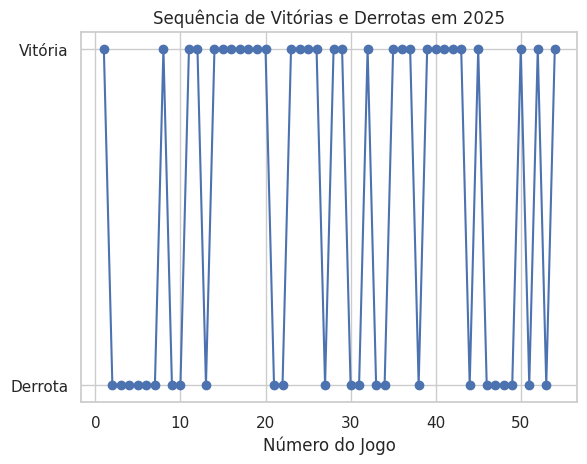

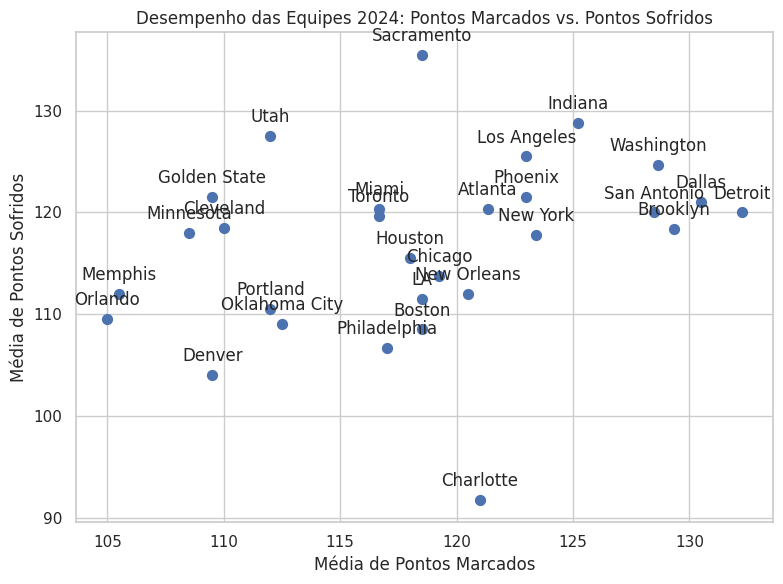

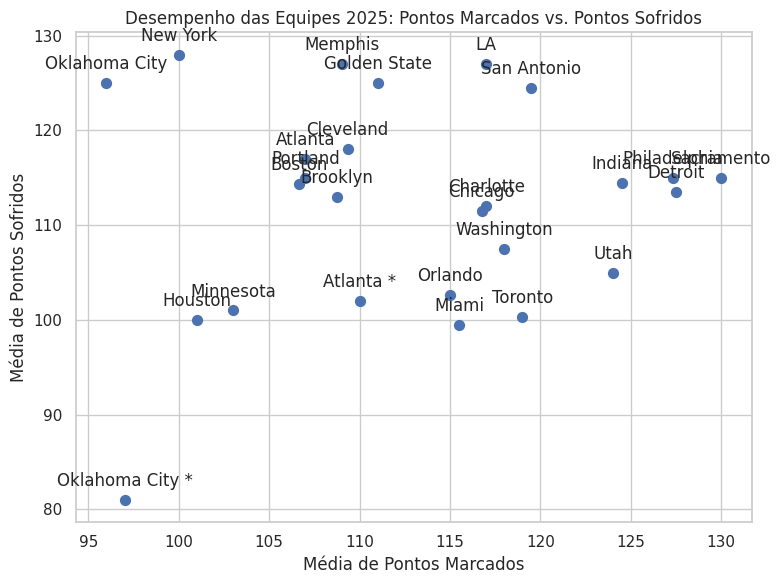

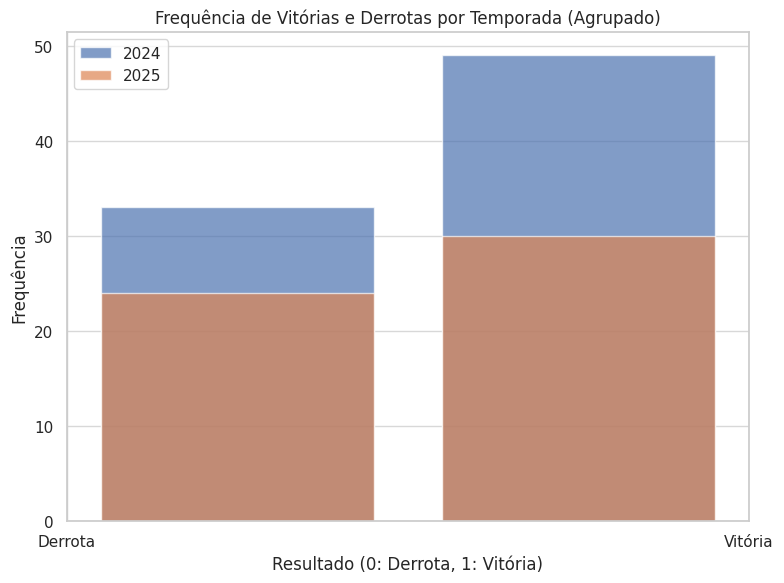

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import pi

sns.set(style="whitegrid")

def draw_graf_V_D(df):
  plt.figure(figsize=(8, 5))
  df.set_index("Temporada").plot(kind="bar", stacked=True, color=["green", "red"])
  plt.title("Vitórias e Derrotas por Temporada")
  plt.ylabel("Número de Jogos")
  plt.xlabel("Temporada")
  plt.legend(["Vitórias", "Derrotas"])
  plt.xticks(rotation=0)
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.show()

def draw_graf_V_D_Casa_Fora(tdf):
  df = tdf.copy()
  head = ["Temporada", 'Total de Vitórias em Casa', 'Total de Vitórias fora de casa',
          'Total de Derrotas em casa', "Total de Derrotas Fora de casa"]
  plt.figure(figsize=(8, 5))
  df[head] = df[head].astype(int)
  bar_width = 0.2
  df[head].set_index("Temporada").plot(kind="bar", stacked=False, color=["green", "blue", "red", "brown"])
  plt.title("Vitórias e Derrotas por Temporada")
  plt.ylabel("Quantidade")
  plt.xlabel("Temporada")
  plt.legend(head[1:])
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.show()

draw_graf_V_D(rf3df)
draw_graf_V_D_Casa_Fora(rf3df)

# Gráfico de Pizza (Percentual de Vitórias e Derrotas Casa/Fora) - RF8

def draw_graf_pie(df, season):
    season_df = df[df["Temporada"] == season].astype(int)  # Use the same DataFrame

    v_casa = season_df["Total de Vitórias em Casa"].iloc[0]
    v_fora = season_df["Total de Vitórias fora de casa"].iloc[0]
    total_v = season_df["Total de Vitórias"].iloc[0]

    d_casa = season_df["Total de Derrotas em casa"].iloc[0]
    d_fora = season_df["Total de Derrotas Fora de casa"].iloc[0]
    total_d = season_df["Total de Derrotas"].iloc[0]

    # Correct Percentage Calculations
    per_v_casa = float(v_casa / (v_casa + v_fora)) * 100 if (v_casa + v_fora) > 0 else 0.0 # Handle potential division by zero
    per_v_fora = float(v_fora / (v_casa + v_fora)) * 100 if (v_casa + v_fora) > 0 else 0.0
    per_d_casa = float(d_casa / (d_casa + d_fora)) * 100 if (d_casa + d_fora) > 0 else 0.0
    per_d_fora = float(d_fora / (d_casa + d_fora)) * 100 if (d_casa + d_fora) > 0 else 0.0


    df_percentual = np.array([per_v_casa, per_v_fora, per_d_casa, per_d_fora])
    labels = ["Vitórias Casa", "Vitórias Fora", "Derrotas Casa", "Derrotas Fora"]
    colors = ["green", "blue", "red", "brown"]

    plt.figure(figsize=(6, 6))
    plt.title(f"Percentual de Vitórias e Derrotas de {season} (Casa/Fora)")
    plt.pie(df_percentual, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90)
    plt.show()


draw_graf_pie(rf3df, 2025)
draw_graf_pie(rf3df, 2024)



def extract_points(placar, is_victory):
    pontos = placar.split("-")
    if not is_victory:
        pontos[0], pontos[1] = pontos[1], pontos[0]
    return int(pontos[0]), int(pontos[1])

rf7dfc = rf7df.copy()

rf7dfc[["Pontos Marcados", "Pontos Sofridos"]] = rf7dfc.apply(lambda row: pd.Series(extract_points(row["Placar"], row["Vitória ou Derrota"] == "Vitória")), axis=1)

def draw_graf_radar(tdf, season):
  df = tdf[tdf["Temporada"].astype(int) == season].copy()

  media_pontos = df.groupby("Casa ou Fora")[["Pontos Marcados", "Pontos Sofridos"]].mean()

  labels = ["Pontos Marcados em Casa", "Pontos Sofridos em Casa", "Pontos Marcados Fora", "Pontos Sofridos Fora"]
  values = [
      media_pontos.loc["Casa", "Pontos Marcados"] if "Casa" in media_pontos.index else 0,
      media_pontos.loc["Casa", "Pontos Sofridos"] if "Casa" in media_pontos.index else 0,
      media_pontos.loc["Fora", "Pontos Marcados"] if "Fora" in media_pontos.index else 0,
      media_pontos.loc["Fora", "Pontos Sofridos"] if "Fora" in media_pontos.index else 0
  ]
  N = len(labels)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  values += values[:1]
  angles += angles[:1]

  fig, ax = plt.subplots(figsize=(4, 5), subplot_kw=dict(polar=True))
  ax.fill(angles, values, color='b', alpha=0.3)
  ax.plot(angles, values, color='b', linewidth=2)
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(labels, fontsize=10)
  plt.title(f"Média de Pontos Marcados e Sofridos em {season} - Casa vs. Fora", fontsize=10, pad=24)
  plt.show()

draw_graf_radar(rf7dfc, 2024)
draw_graf_radar(rf7dfc, 2025)

def draw_graf_lines(tdf, season):
  df = tdf[tdf["Temporada"].astype(int) == season].copy()

  df['Resultado'] = df['Vitória ou Derrota'].apply(lambda x: 1 if x == 'Vitória' else 0)

  df['Jogo'] = range(1, len(df) + 1)

  plt.plot(df['Jogo'], df['Resultado'], marker='o', linestyle='-')
  plt.xlabel('Número do Jogo')
  plt.title(f'Sequência de Vitórias e Derrotas em {season}')
  plt.yticks([0, 1], ['Derrota', 'Vitória'])
  plt.grid(True)
  plt.show()

draw_graf_lines(rf7dfc, 2024)
draw_graf_lines(rf7dfc, 2025)

#Gráfico de Dispersão exibindo equipes e a média de pontos marcados e sofridos durante a temporada
def draw_graf_dispersao(tdf, season):
  df = tdf[tdf["Temporada"].astype(int) == season].copy()
  medias = df.groupby('Adversário')[['Pontos Marcados', 'Pontos Sofridos']].mean().reset_index()

  plt.figure(figsize=(8, 6))
  plt.scatter(medias['Pontos Marcados'], medias['Pontos Sofridos'], s=50)

  plt.xlabel('Média de Pontos Marcados')
  plt.ylabel('Média de Pontos Sofridos')
  plt.title(f'Desempenho das Equipes {season}: Pontos Marcados vs. Pontos Sofridos')

  for i, equipe in enumerate(medias['Adversário']):
      plt.annotate(equipe, (medias['Pontos Marcados'][i], medias['Pontos Sofridos'][i]), textcoords="offset points", xytext=(0,10), ha='center')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

draw_graf_dispersao(rf7dfc, 2024)
draw_graf_dispersao(rf7dfc, 2025)

def draw_graf_histogram(tdf):
  df = tdf.copy()
  df['Resultado_Num'] = df['Vitória ou Derrota'].map({'Vitória': 1, 'Derrota': 0})
  plt.figure(figsize=(8,6))
  for temporada in df['Temporada'].unique():
      temporada_df = df[df['Temporada'] == temporada]
      plt.hist(temporada_df['Resultado_Num'], bins=2, rwidth=0.8, alpha=0.7, label=temporada)

  plt.xlabel('Resultado (0: Derrota, 1: Vitória)')
  plt.ylabel('Frequência')
  plt.title('Frequência de Vitórias e Derrotas por Temporada (Agrupado)')
  plt.xticks([0, 1], ['Derrota', 'Vitória'])
  plt.legend()
  plt.grid(axis='y', alpha=0.75)
  plt.tight_layout()
  plt.show()


draw_graf_histogram(rf7dfc)

#Apresente um gráfico da sua escolha para exibir os dados referentes a RF6df e  do RF7df.
def draw_graf_barras(tdf):
  df = tdf.copy()
  df['Temporada'] = df['Temporada'].astype(str)
